In [289]:
from collections import defaultdict
from Bio.SeqIO.FastaIO import SimpleFastaParser as sfp
from Bio import SeqIO, SearchIO, Entrez
import subprocess as sp
import seaborn as sns
import numpy as np
import pandas as pd
import os, glob, math, re, gzip
import geopandas as gpd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from Bio import Entrez
Entrez.email = "ajaffe@stanford.edu"
from bs4 import BeautifulSoup

In [290]:
def cmdir(path):
    if not os.path.isdir(path):
        os.mkdir(path)

def scaffold(gene):
    if gene != "None":
        try: return re.search("(.+?)_[0-9]+$", gene).group(1)
        except: print(gene)

def sbatch(name, cpus, cmd):
    return "sbatch -J %s -p serc -t 1- -c %d --mem %dG --wrap '%s'" %(name, cpus, cpus*8, cmd)

In [291]:
rootdir = "/scratch/users/ajaffe/deepeco/"
cmdir(rootdir + "diversity")

## compute

In [4]:
cmdir(rootdir + "diversity/global")

### read in non-redundant data

In [292]:
nr_genomes = pd.read_csv(rootdir + "tables/nonredundant_genome_info.tsv", sep="\t")
nr_genomes.head()

,genome,classification,checkm_completeness,checkm_redundancy,primary_cluster,secondary_cluster,representative,scluster_rubisco_set,phylum
0,OceanDNA-b21631,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,82.99,2.48,1,1_0,True,II_III_II_III,d__Bacteria_p__Patescibacteria
1,OceanDNA-b21628,d__Bacteria;p__Patescibacteria;c__Gracilibacte...,79.21,2.09,3,3_0,True,II_III_II_III,d__Bacteria_p__Patescibacteria
2,TARA_SAMEA4397330_METAG_GFBBFFPE,d__Bacteria;p__Proteobacteria;c__Alphaproteoba...,88.16,1.10,4,4_1,True,II_II,d__Bacteria_p__Proteobacteria
3,GCA_030739585.1_ASM3073958v1_genomic,d__Archaea;p__Thermoproteota;c__Bathyarchaeia;...,93.93,1.87,5,5_1,True,III_B,d__Archaea_p__Thermoproteota
4,OceanDNA-b35769,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,95.16,0.59,6,6_1,True,I,d__Bacteria_p__Proteobacteria


### prep genomes

In [6]:
# create fasta, genes, stb for nr db
fasta = open(rootdir + "diversity/nonredundant_genomes.fna", "w")
stb = open(rootdir + "diversity/nonredundant_genomes.stb", "w")

for key, row in nr_genomes.iterrows():
    
    # locate the file
    gpath = rootdir + "genomes/first_pass/%s.fa" %(row["genome"])
    
    # write merged fasta and stb
    for record in sfp(open(gpath)):
        fasta.write(">%s\n%s\n" %(record[0].split(" ")[0], record[1]))
        stb.write("%s\t%s\n" %(record[0].split(" ")[0], row["genome"]))

fasta.close()
stb.close()

In [8]:
# create bowtie idx
cmd = "bowtie2-build %s %s" %(rootdir + "diversity/nonredundant_genomes.fna", \
                              rootdir + "diversity/global/nr_genomes.idx")
print(cmd)

bowtie2-build /scratch/users/ajaffe/deepeco/diversity/nonredundant_genomes.fna /scratch/users/ajaffe/deepeco/diversity/global/nr_genomes.idx


In [13]:
# write to snakefile config
with open(rootdir + "diversity/global/config.yaml", "w") as out:
    
    out.write("fasta: %s\n" %(rootdir + "diversity/nonredundant_genomes.fna"))
    out.write("stbfile: %s\n" %(rootdir + "diversity/nonredundant_genomes.stb"))
    out.write("idx: %s\n" %(rootdir + "diversity/global/nr_genomes.idx"))

### get input samples - external

In [5]:
def retrieve_coords(row):
    
    lat,lon = 'None', 'None'
    
    try:
        
        handle = Entrez.efetch(db="sra", id=row["run_accession"], rettype="runinfo", retmode="xml")
        biosample = BeautifulSoup(handle, "html.parser").find("biosample").string

        handle = Entrez.efetch(db="biosample", id=biosample, rettype="summary", retmode="xml")
        biosample_results = BeautifulSoup(handle, "html.parser")
        title = biosample_results.find("title").string

        # correct for some w/o metadata
        if "Tsementzi" in row["sample"]:
            lat,lon = 18.9,-104.9
        elif "moomz" in title.lower():
            lat,lon = -20.0,-70.23
        elif row["station"] == "PS2":
            lat,lon=16,-105
        elif row["station"] == "PS3":
            lat, lon = 18,-102
        else:
            for attribute in biosample_results.findAll("attribute"):
                if attribute["attribute_name"] == "lat_lon":
                    attr_list = attribute.string.split(" ")
                    ns = 1 if attr_list[1] == "N" else -1
                    ew = 1 if attr_list[3] == "E" else -1
                    lat = float(attr_list[0]) * ns
                    lon = float(attr_list[2]) * ew
    except: pass
    
    return lat, lon

In [368]:
# OMD studies
omd_metadata = pd.read_csv(rootdir + "tables/omd_metadata.csv")
omd_metadata = omd_metadata[[c for c in omd_metadata.columns if "Unnamed" not in c]]

# run accessions
omd_public = pd.concat(pd.read_csv(item) for item in glob.glob(rootdir + "tables/omd*metag.csv"))
omd_metadata = omd_metadata.merge(omd_public[["sample_name", "run_accessions"]], \
                                  how="left", left_on="Sample", right_on="sample_name").drop("sample_name", axis=1)
omd_subset = omd_metadata[["Sample", "dataset", "station", "ocean_province", "latitude", \
              "longitude", "depth_num", "size_fraction", "oxygen [µmol/kg]", "run_accessions"]]
omd_subset.columns = ["sample", "dataset", "station", "ocean_province", "latitude", "longitude", "depth",
                      "size_fraction", "oxygen_conc", "run_accession"]
omd_subset.head(2)

,sample,dataset,station,ocean_province,latitude,longitude,depth,size_fraction,oxygen_conc,run_accession
0,TARA_SAMEA2619625_METAG,Tara Oceans,TARA_011,Mediterranean Sea,41.6686,2.7996,9.0,<-0.22,NaN,ERR599383
1,TARA_SAMEA2619872_METAG,Tara Oceans,TARA_033,Red Sea,21.9467,38.2517,5.0,<-0.22,183.589125,ERR599350


In [369]:
ind_metag = pd.read_csv(rootdir + "tables/wang_et_al_scidata_metag.csv")[["Sample IDs", "SRA accession numbers (Metagenomes)"]]
ind_metag.columns = ["sample_id", "sra_accession"]
ind_env = pd.read_csv(rootdir + "tables/wang_et_al_scidata_env.csv")[["Sample IDs", "Longitude", "Latitude",
                                                                     "Depth\n(m)", "DO\n(mg*L-1)"]]
ind_env.columns = ["sample_id", "longitude", "latitude", "depth", "oxygen_conc"]
ind_merged = ind_metag.merge(ind_env, how="left", on="sample_id")
ind_merged["station"] = ind_merged["sample_id"].apply(lambda x: x.split("-")[1])
ind_merged["dataset"] = "Indian Ocean Transect"
ind_merged["ocean_province"] = "Indian Ocean"
ind_merged["size_fraction"] = ">0.22 µm"
ind_subset = ind_merged.rename(columns = {"sra_accession":"run_accession", "sample_id":"sample"})
ind_subset.head(2)

,sample,run_accession,longitude,latitude,depth,oxygen_conc,station,dataset,ocean_province,size_fraction
0,S10-1-5,SRR26502685,86.95,-10.0,5,6.19,1,Indian Ocean Transect,Indian Ocean,>0.22 µm
1,S10-1-DCM,SRR26502684,86.95,-10.0,65,2.84,1,Indian Ocean Transect,Indian Ocean,>0.22 µm


In [370]:
omz_metag = pd.read_csv(rootdir + "tables/omz_sample_curation.csv").fillna({"Station ID":"None"})
omz_subset = omz_metag[["Metagenome ID", "Station ID", "sra_accession", "Ocean", "Filter size fraction", "depth", "oxygen"]]
omz_subset.columns = ["sample", "station", "run_accession", "ocean_province", "size_fraction", "depth", "oxygen_conc"]
omz_subset["dataset"] = "OMZ"

geo_locs = [retrieve_coords(row) for key, row in omz_subset.iterrows()]
omz_subset["latitude"] = [item[0] for item in geo_locs]
omz_subset["longitude"] = [item[1] for item in geo_locs]
omz_subset.head(2)

,sample,station,run_accession,ocean_province,size_fraction,depth,oxygen_conc,dataset,latitude,longitude
0,Fuchsman_SRR4465024,136,SRR4465024,Eastern Tropical North Pacific Ocean,>0.2 μm,100,2.34,OMZ,17.0327,-106.5328
1,Fuchsman_SRR4465025,136,SRR4465025,Eastern Tropical North Pacific Ocean,>0.2 μm,90,10.28,OMZ,17.0327,-106.5328


N.B. some will fail spontaneously so may need to retry a few times.

In [371]:
### recently published MALAspina
malaspina = pd.read_csv(rootdir + "tables/malaspina_2024.csv")
malaspina_md = pd.read_csv(rootdir + "tables/malaspina_2024_details.csv")
malaspina = malaspina[["MPCode", "run_accession"]].merge(malaspina_md[["MPCode", "sampling_station", "latitude", 
                                          "longitude", "depth", "oxygen_concentration", "marine_region"]], how="left", on="MPCode")
malaspina["dataset"] = "Malaspina"
malaspina["size_fraction"] = "0.22-3 μm"
malaspina = malaspina.rename(columns={"MPCode":"sample", "sampling_station":"station", 
                                     "marine_region":"ocean_province", "oxygen_concentration":"oxygen_conc"})
malaspina.head()

,sample,run_accession,station,latitude,longitude,depth,oxygen_conc,ocean_province,dataset,size_fraction
0,MP0311,"ERR10114618,ERR10114617,ERR10114526,ERR10114430",MH_019,-7.213764,-29.338658,3,4.3259,[SAO] South Atlantic Ocean (MRGID:1914),Malaspina,0.22-3 μm
1,MP0313,"ERR10114721,ERR10114720,ERR10114620,ERR10114619",MH_019,-7.283367,-29.322468,4000,5.3994,[SAO] South Atlantic Ocean (MRGID:1914),Malaspina,0.22-3 μm
2,MP0315,"ERR10114833,ERR10114830,ERR10114826,ERR10114822",MH_019,-7.283367,-29.322468,1600,5.045,[SAO] South Atlantic Ocean (MRGID:1914),Malaspina,0.22-3 μm
3,MP0317,"ERR10114842,ERR10114841,ERR10114838,ERR10114835",MH_019,-7.283367,-29.322468,800,3.4388,[SAO] South Atlantic Ocean (MRGID:1914),Malaspina,0.22-3 μm
4,MP0319,"ERR10114911,ERR10114910,ERR10114908,ERR10114843",MH_019,-7.283367,-29.322468,400,1.6056,[SAO] South Atlantic Ocean (MRGID:1914),Malaspina,0.22-3 μm


In [29]:
with open(rootdir + "diversity/global/sample_list.tsv", "w") as out:
    
    # everything in omd except for hots/bats
    for key, row in omd_subset.iterrows():
        if ("HOTS" not in row["sample"]) and ("BATS" not in row["Sample"]):
            out.write("%s\t%s\n" %(row["sample"], row["run_accession"]))
    
    # wang et al sci data (indian ocean)
    for key, row in ind_merged.iterrows():
        out.write("%s\t%s\n" %(row["sample"], row["run_accession"]))
        
    # various omz studies, curated
    for key, row in omz_metag.iterrows():
        out.write("%s\t%s\n" %(row["sample"], row["run_accession"]))
    
    # malaspina 2024 metagenomes
    for key, row in malaspina.iterrows():
        out.write("%s\t%s\n" %(row["MPCode"], row["run_accession"]))

### get input samples - internal

cp reads in from oc17 dir. rename...

In [25]:
with open(rootdir + "diversity/global/rename_reads.sh", "w") as out:
    for readfile in glob.glob(rootdir + "diversity/global/trimmed_reads/*0m*"):
        #m = re.search("(.+?)R([12]).+", os.path.basename(readfile))
        m = re.search("([0-9]+)m([0-9]+)m_([12])", os.path.basename(readfile))
        #filename = "%s%s.fastq.gz" %(m.group(1), m.group(2))
        filename = "%s_%sm_%s.fastq.gz" %(site_dict["A" + m.group(1)], m.group(2), m.group(3))
        cmd = "mv %s %s/%s" %(readfile, os.path.dirname(readfile), filename)
        out.write(cmd + "\n")

In [148]:
site_dict = {"A500":"OC2", "A3000":"OC3", 
             "A3500":"OC4", "A4000":"OC5", "A4500": "OC6"}
rev_site_dict = {site_dict[key]:key.lstrip("A") for key in site_dict}

In [372]:
oc = pd.read_csv(rootdir + "tables/oc17_samples.tsv", sep="\t")[["site", "depth", "latitude", "longitude"]]
oc.columns = ["station", "depth", "latitude", "longitude"]
oc["sample"] = oc.apply(lambda x: x["station"] + "_" + str(x["depth"]) + "m", axis=1)
oc["run_accession"] = "n/a"
oc["oxygen_conc"] = "n/a"
oc["dataset"] = "OC1703A"
oc["ocean_province"] = "Northeastern Pacific"
oc["size_fraction"] = ">0.2 μm"
oc.head(2)

,station,depth,latitude,longitude,sample,run_accession,oxygen_conc,dataset,ocean_province,size_fraction
0,OC1,50,37.134378,-122.54423,OC1_50m,n/a,n/a,OC1703A,Northeastern Pacific,>0.2 μm
1,OC2,50,37.036683,-122.70133,OC2_50m,n/a,n/a,OC1703A,Northeastern Pacific,>0.2 μm


In [30]:
with open(rootdir + "diversity/global/sample_list.tsv", "a") as out:
    for key, row in oc.iterrows():
        if row["station"] != 'OC1':
            old_prefix = "%sm%sm" %(rev_site_dict[row["station"]], row["depth"])
            new_prefix = "%s_%sm" %(row["station"], row["depth"])
            out.write("%s\t%s\n" %(new_prefix, old_prefix))

### run + check

Move snakefile from local into `/mapping`.

In [33]:
cmd = 'snakemake --keep-going -s DNASnakefile \
      --config sample_list=%s maxthreads=20 \
      --cluster "sbatch -p serc -c 20 -t 1- --mem 160G" --jobs 25' %(rootdir + "diversity/global/sample_list.tsv")
print(cmd)

snakemake --keep-going -s DNASnakefile       --config sample_list=/scratch/users/ajaffe/deepeco/diversity/global/sample_list.tsv maxthreads=20       --cluster "sbatch -p serc -c 20 -t 1- --mem 160G" --jobs 25


In [ ]:
samples_to_run = [item.split("\t")[0] \
                  for item in open(rootdir + "diversity/global/sample_list.tsv").readlines()]
succeeded = set([item.split("/")[-3] for item in \
                 glob.glob(rootdir + "diversity/global/instrain/*/output/*info.tsv")])

print("%d of %d samples successfully mapped." %(len(succeeded), len(samples_to_run)))

### process

In [ ]:
strain_results = []

for item in glob.glob(rootdir + "diversity/global/instrain/*/output/*_genome_info.tsv"):
    
    table = pd.read_csv(item, sep="\t")
    table["sample"] = item.split("/")[-3]
    strain_results.append(table)

all_results = pd.concat(strain_results).reset_index().drop("index", axis=1)
len(strain_results)

In [6]:
all_results = all_results[["sample"] + [c for c in all_results.columns if c != "sample"]]
# important breadth filtering
all_results["breadth_ratio"] = all_results.apply(lambda x: x["breadth"]/x["breadth_expected"], axis=1)
filt_results = all_results[(all_results["breadth"]>=0.50) & (all_results["breadth_ratio"]>=0.50)]
filt_results.sort_values("coverage", ascending=False).head()

,sample,genome,coverage,breadth,nucl_diversity,length,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,...,consensus_divergent_sites,population_divergent_sites,SNS_count,SNV_count,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,reads_unfiltered_reads,divergent_site_count,breadth_ratio
468465,TARA_SAMEA2621536_METAG,OceanDNA-b43160,1273.189885,0.996298,0.022065,1042901,468,468,1470,527.241704,...,11388,2787,2509,55583,8604509,10444535,0.974693,21290119,58092,0.996298
541872,TARA_SAMEA2621509_METAG,OceanDNA-b43160,1029.557104,0.996102,0.021904,1042901,468,468,1176,435.666555,...,11148,2626,2373,55760,6930535,8370394,0.974420,17044645,58133,0.996102
116790,TARA_SAMEA2622766_METAG,MARD_SAMEA4707912_REFG_MMP4707912,886.082551,0.945094,0.022321,2210892,17,16,1039,540.982362,...,37318,15204,14138,112667,12711014,16212514,0.969759,33017561,126805,0.945094
25414,TARA_SAMEA2621839_METAG,AG-321-E21,879.467228,0.932536,0.019783,1314750,48,47,1028,544.052568,...,10970,1683,1550,55552,7034299,9036139,0.977515,18278639,57102,0.932536
456,TARA_SAMEA2619952_METAG,GORG_SAMEA6075597_SAGS_AG390A21,664.240954,0.970371,0.034975,796808,57,56,549,603.633755,...,14202,3145,2673,65329,3304734,5411047,0.952706,11542285,68002,0.970371


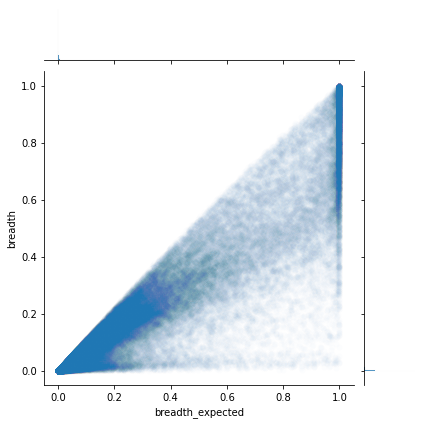

In [7]:
sns.jointplot(
    x="breadth_expected", y="breadth", data=all_results.query("breadth>0"), kind="scatter", alpha=0.01,
)
plt.show()

### calculate abundance

In [8]:
# total sample reads (trimmed)
total_reads = pd.concat(pd.read_csv(item, sep="\t", header=None) for item in \
             glob.glob(rootdir + "diversity/global/trimmed_reads/counts/*"))
total_reads.columns = ["sample", "total_reads"]
# total mapped reads
mapped_reads = all_results.groupby("sample", as_index=False).aggregate({"filtered_read_pair_count":lambda x: sum(x)*2})
mapped_reads.columns = ["sample", "mapped_reads"]
filt_results = filt_results.merge(total_reads, how="left", on="sample").merge(mapped_reads, how="left", on="sample")
filt_results.head(2)

,sample,genome,coverage,breadth,nucl_diversity,length,true_scaffolds,detected_scaffolds,coverage_median,coverage_std,...,SNS_count,SNV_count,filtered_read_pair_count,reads_unfiltered_pairs,reads_mean_PID,reads_unfiltered_reads,divergent_site_count,breadth_ratio,total_reads,mapped_reads
0,TARA_SAMEA2621061_METAG,TARA_SAMEA2620967_METAG_GMIJNKGA,1.139056,0.657023,0.002075,3881218,14,14,1,1.150179,...,49,77,29767,30353,0.989870,62041,126,1.035916,79121468,92032
1,TARA_SAMEA2619952_METAG,AG-349-P05,3.059923,0.658075,0.019768,880559,43,32,2,5.512895,...,2235,5860,16913,42008,0.940899,157880,8095,0.705391,396115638,19977280


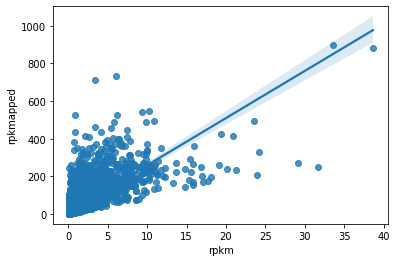

In [9]:
# calculate abundances
filt_results["rpk"] = filt_results.apply(lambda x: (x["filtered_read_pair_count"]*2)/(x["length"]/1000), axis=1)
filt_results["rpkm"] = filt_results.apply(lambda x: x["rpk"]/(x["total_reads"]/1e6), axis=1)
filt_results["rpkmapped"] = filt_results.apply(lambda x: x["rpk"]/(x["mapped_reads"]/1e6), axis=1)
sns.regplot(x="rpkm", y="rpkmapped", data=filt_results)
plt.show()

In [79]:
## export
#filt_results.to_csv(rootdir + "tables/filtered_instrain_results.tsv", sep="\t", index=False)
cmd = "rclone copy %s drive:deepeco/tables" %(rootdir + "tables/filtered_instrain_results.tsv")
print(cmd)

rclone copy /scratch/users/ajaffe/deepeco/tables/filtered_instrain_results.tsv drive:deepeco/tables


## analyze

In [413]:
sample_subset = pd.read_csv(rootdir + "tables/sample_subset.tsv", sep="\t")
filt_results = pd.read_csv(rootdir + "tables/filtered_instrain_results.tsv", sep="\t")
# saved version was too lenient on breadth
filt_results = filt_results.query("breadth>=0.50")

### plot out sampling effort

In [414]:
# bring back sample and genome metadata 
#sample_subset = pd.concat([omd_subset, ind_subset, omz_subset, malaspina, oc]).fillna("None")
# remove integrated depth samples
sample_subset = sample_subset.query("depth!='None'")
# filter out stationary time series
sample_subset = sample_subset[(~sample_subset["dataset"].str.contains("Hawaii")) & 
                              (~sample_subset["dataset"].str.contains("Bermuda"))]
# restrict to those successfully mapped
sample_subset = sample_subset[sample_subset["sample"].isin(filt_results["sample"].unique())]
sample_subset["depth_numeric"] = sample_subset["depth"].apply(lambda x: int(x))
sample_subset.head()

,sample,dataset,station,ocean_province,latitude,longitude,depth,size_fraction,oxygen_conc,run_accession,depth_numeric
0,TARA_SAMEA2619625_METAG,Tara Oceans,TARA_011,Mediterranean Sea,41.6686,2.7996,9.0,<-0.22,NaN,ERR599383,9
1,TARA_SAMEA2619872_METAG,Tara Oceans,TARA_033,Red Sea,21.9467,38.2517,5.0,<-0.22,183.589125,ERR599350,5
2,TARA_SAMEA2619992_METAG,Tara Oceans,TARA_037,Indian Ocean,20.8457,63.5851,600.0,<-0.22,2.81625,ERR599372,600
3,TARA_SAMEA2620053_METAG,Tara Oceans,TARA_038,Indian Ocean,19.0351,64.5638,340.0,<-0.22,2.9502,ERR599379,340
4,TARA_SAMEA2620120_METAG,Tara Oceans,TARA_039,Indian Ocean,18.7341,66.3896,270.0,<-0.22,3.12405,ERR599360,270


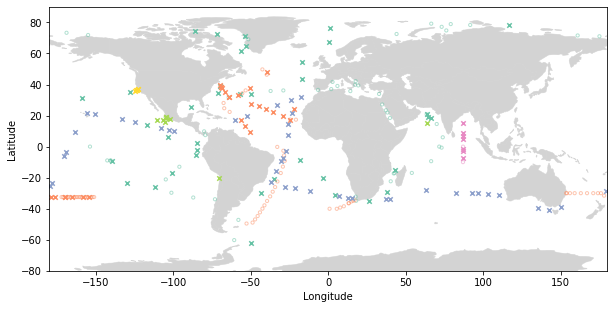

In [415]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
fig, ax = plt.subplots(figsize=(10, 5))
map_kws = dict(linewidth=.5, edgecolor="lightgrey")
worldmap.plot(color="lightgrey", ax=ax, **map_kws)

datasets = list(sample_subset["dataset"].unique())

for dataset in datasets:
    
    table = sample_subset[sample_subset["dataset"]==dataset]
    # take deepest sample per station
    table_dd = table.sort_values("depth_numeric", ascending=False).drop_duplicates(["dataset", "station"])
    color = list(sns.color_palette("Set2").as_hex())[datasets.index(dataset)]
    
    # shallow stations
    plt.scatter("longitude", "latitude", 
        data=table_dd.query("depth_numeric<200"), 
                s=10,facecolors='none', edgecolors=color, alpha=0.5)
    # deep stations
    plt.scatter("longitude", "latitude", 
        data=table_dd.query("depth_numeric>=200"), 
                c=color,s=20, marker="x")
    
plt.xlim([-180, 180])
plt.ylim([-80, 90])
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.savefig(rootdir + "figures/world_map.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

In [86]:
#sample_subset.to_csv(rootdir + "tables/sample_subset.tsv", sep="\t", index=False)
cmd = "rclone copy %s drive:deepeco/tables" %(rootdir + "tables/sample_subset.tsv")
print(cmd)

rclone copy /scratch/users/ajaffe/deepeco/tables/sample_subset.tsv drive:deepeco/tables


### by form by depth

In [341]:
genome_subset = nr_genomes[["genome", "classification", "scluster_rubisco_set"]]
merged = filt_results[["sample", "genome", "coverage", "rpkm", "rpkmapped"]].\
                                    merge(sample_subset, on="sample", how="left").\
                                    merge(genome_subset, on="genome", how="left").fillna("None")
# remove integrated depth samples
# remove dna virus, small virus, etc size fractions
merged = merged[(merged["depth_numeric"]!='None') & \
                (~merged["size_fraction"].isin(["0.45-0.8", "0.22-0.45",'<-0.22','0.1-0.22']))]
merged["size_fraction"].value_counts()

size_fraction
0.22-3         3966
0.2<-          3359
0.22-3 μm      2025
0.22-1.6       1613
>0.2 μm         943
>0.22 µm        564
>0.22 μm        369
0.2-0.8         213
0.8-20           88
0.22-1.6 μm      69
None             39
Name: count, dtype: int64

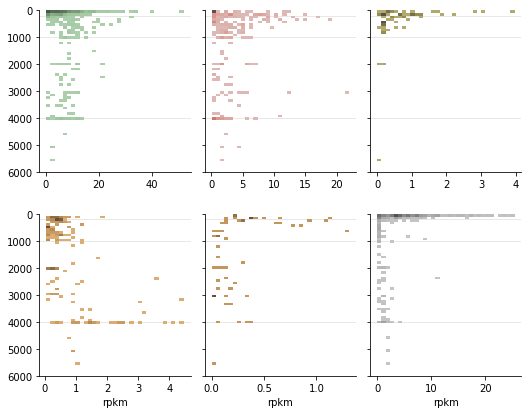

In [342]:
merged["scluster_bonafide_set"] = merged["scluster_rubisco_set"].apply(lambda x: x.replace(",IV","").replace(", IV", ""))
#merged = merged[merged["genome"].isin(["BGEO_SAMN07136798_METAG_LAMHFHAM", "MALA_SAMN05422163_METAG_GEDEEMDE"])]
# first sum within sample (for whole community potential)
tmp = merged[merged["scluster_bonafide_set"].isin(["I", "II_II", "I,II_II", "III_A", "III_Like", "IV"])].groupby(["sample","scluster_bonafide_set"], as_index=False)\
    .aggregate({"rpkm":"sum", "rpkmapped":"sum", "depth_numeric":"first", "ocean_province":"first"})

## add in dummy for deepest to standardize binning across forms
deepest = max(tmp["depth_numeric"])
deepest_forms = tmp[tmp["depth_numeric"]==deepest]["scluster_bonafide_set"].unique()

for form in tmp["scluster_bonafide_set"].unique():
    if form not in deepest_forms:
        dummy = pd.DataFrame({"sample":["dummy"], "scluster_bonafide_set":[form], "rpkm":[0], "rpkmapped":[0], 
              "depth_numeric":[deepest], "ocean_province":["dummy"]})
        tmp = pd.concat([tmp, dummy])
        
# create binned dataframe for mean line
bin_width = 250
bins = [i for i in range(0, int(round(tmp["depth_numeric"].max(),0) + bin_width), bin_width)]
labels = [(x-(bin_width/2)) for x in bins if x!=0]
tmp['binned'] = pd.cut(tmp['depth_numeric'], bins=bins, labels=labels)

corder = ["I", "II_II", "I,II_II", "III_A", "III_Like","IV"]
#corder = ["I", "II_II"]
palette={"I":"#A6D6A6", "I,II_II":"#c9bd75", "II_II":"#E2B2AC", "II_III_II_III":"#ff995c",
         "III_A": "#EDB66E", "III_B": "#EDB66E", "III_C": "#EDB66E", "III_Like": "#EDB66E", "IV":"darkgrey"}
g = sns.FacetGrid(tmp, col="scluster_bonafide_set", col_order=corder, col_wrap=3,height=3, aspect=0.85,
                  hue="scluster_bonafide_set",palette=palette, sharex=False, sharey=True)
g.map(sns.histplot,'rpkm','depth_numeric', stat="density", 
      bins=(33, int(round(len(labels)*2.5,0))))
g.set_titles("").set(ylabel="").set(ylim=(6000,0))
#g.map(sns.lineplot, 'rpkm', 'binned', orient='y',
      #errorbar='ci', estimator='mean').set_titles("").set(ylabel="").set(ylim=(6000,0))

for i,ax in enumerate(g.axes.flat):
    for k in [200,1000,4000]:
        ax.axhline(k, ls="-", zorder=0, linewidth=0.5,color="lightgrey") 
plt.savefig(rootdir + "figures/global_all_forms_wide.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

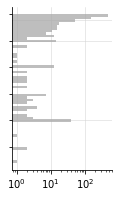

In [343]:
### sampling effort
plt.figure(figsize=(3*0.6,3))
merged["depth_negative"] = merged["depth_numeric"].apply(lambda x: x*-1)
ax = sns.histplot(y=merged.drop_duplicates("sample")["depth_negative"], 
             bins=int(round(len(labels)*2.5,0)), color="darkgrey", linewidth=0)
ax.set(yticklabels=[]) 
plt.xscale("log")

for k in [-200,-1000,-4000]:
    plt.axhline(k, ls="-", zorder=0, linewidth=0.5,color="lightgrey")
for k in [1,10,100]:
    plt.axvline(k, ls="-", zorder=0, linewidth=0.5,color="lightgrey")

plt.ylabel("");
plt.xlabel("")
sns.despine(top=True)
plt.savefig(rootdir + "figures/global_sampling_long.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

## species - level

In [384]:
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

### define locales

In [385]:
## uses code from https://geoffboeing.com/2014/08/clustering-to-reduce-spatial-data-set-size/
## cite https://osf.io/preprints/socarxiv/nzhdc

In [386]:
# restrict to deep water samples
coords = sample_subset.query("depth_numeric>=200").query("latitude!='None'")[["latitude", "longitude"]].values.astype(float)
coord_info = defaultdict(list)

for thresh in [0.1, 1, 10, 50, 100]:
    
    kms_per_radian = 6371.0088
    epsilon = thresh / kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
    
    for i, cluster in enumerate(clusters):
        for coord in cluster:
            coord_info["latitude"].append(coord[0])
            coord_info["longitude"].append(coord[1])
            coord_info["epsilon"].append("c%.1fkm" %(thresh))
            coord_info["cluster"].append(i)

coord_df = pd.DataFrame(coord_info).drop_duplicates()
coord_df.head()

,latitude,longitude,epsilon,cluster
0,20.8457,63.5851,c0.1km,0
3,19.0351,64.5638,c0.1km,1
6,18.7341,66.3896,c0.1km,2
9,-15.3379,43.2948,c0.1km,3
11,-29.5046,37.9599,c0.1km,4


In [387]:
coord_piv = coord_df.pivot(index=["latitude", "longitude"], columns="epsilon", values="cluster").reset_index()
coord_piv.head()

epsilon,latitude,longitude,c0.1km,c1.0km,c10.0km,c100.0km,c50.0km
0,-61.968900,-49.501700,8,8,8,8,8
1,-40.550466,142.497224,125,122,119,112,115
2,-39.230000,135.190000,89,86,83,80,82
3,-38.640000,150.410000,90,87,84,81,83
4,-35.188900,26.290500,34,34,34,34,34


### assess locale detection

In [388]:
merged = filt_results[["sample", "genome", "coverage", "rpkm", "rpkmapped"]].\
                                    merge(sample_subset, on="sample", how="left").\
                                    merge(genome_subset, on="genome", how="left").\
                                    merge(coord_piv, on=["latitude", "longitude"], how="left").fillna("None")
# remove those with bad depths
merged = merged[(merged["depth_numeric"]!='None')]
# remove non-bonafides
# filter to deep samples
merged = merged.query("scluster_rubisco_set!='IV'").query("depth_numeric>=200")
totals = {thresh:len(coord_piv[thresh].unique()) for thresh in coord_piv.columns if thresh.startswith("c")}
agg_dict = {thresh:"nunique" for thresh in coord_piv.columns if thresh.startswith("c")}
merged_gb = merged.groupby(["genome", "classification"], as_index=False).aggregate(agg_dict)

for thresh in coord_piv.columns:
    if thresh.startswith("c"):
        tmp = [round((x/totals[thresh])*100,4) for x in merged_gb[thresh]]
        merged_gb[thresh.replace("c", "p")] = tmp

merged_gb.head()

,genome,classification,c0.1km,c1.0km,c10.0km,c100.0km,c50.0km,p0.1km,p1.0km,p10.0km,p100.0km,p50.0km
0,AAA007_O20_contigs_output_clean,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,60,59,59,55,57,43.7956,44.0299,45.3846,45.8333,45.9677
1,AG-311-D23,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia...,1,1,1,1,1,0.7299,0.7463,0.7692,0.8333,0.8065
2,AG-313-C04,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,1,1,1,1,1,0.7299,0.7463,0.7692,0.8333,0.8065
3,AG-313-L21,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,2,2,2,2,2,1.4599,1.4925,1.5385,1.6667,1.6129
4,AG-319-D09,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,3,3,3,3,3,2.1898,2.2388,2.3077,2.5000,2.4194


### assess mean abundance + plot

In [352]:
def assign_label(taxstring):
    
    s = taxstring.split(";")
    if "Proteobacteria" in taxstring:
        return "%s;%s" %(s[2], s[3])
    else: return "%s;%s" %(s[1], s[3])

In [353]:
p = list(sns.color_palette("tab20c").as_hex())
color_mapping = {'c__Alphaproteobacteria;o__Rhodobacterales': p[0],
                 'c__Alphaproteobacteria;o__Rhodospirillales': p[1],
                 'c__Gammaproteobacteria;o__Arenicellales':p[12],
                 'c__Gammaproteobacteria;o__Burkholderiales': p[13],
                 'c__Gammaproteobacteria;o__PS1':p[14],
                 'c__Gammaproteobacteria;o__Pseudomonadales':p[15],
                 'p__Cyanobacteria;o__PCC-6307': p[8],
                 'p__Marinisomatota;o__Marinisomatales': p[4],
                 'p__SAR324;o__SAR324': p[5],
                 'p__Verrucomicrobiota;o__Pedosphaerales': p[6],
                 'p__Thermoproteota;o__Nitrososphaerales': p[7],
                 'other': p[-1]}

In [354]:
# remove integrated depth samples
# remove dna virus, small virus, etc size fractions
merged = merged[(merged["depth_numeric"]!='None') & \
                (~merged["size_fraction"].isin(["0.45-0.8", "0.22-0.45",'<-0.22','0.1-0.22']))]
abund_gb = merged.groupby(["genome"], as_index=False).aggregate({"rpkm":"mean"})
both_gb = merged_gb.merge(abund_gb, how="left", on="genome").fillna("None").query("rpkm!='None'")
both_gb["display_name"] = both_gb["classification"].apply(assign_label)
both_gb["plot_name"] = both_gb["display_name"].apply(lambda x: x if x in color_mapping.keys() else "other")
both_gb.sort_values("p1.0km", ascending=False)[0:10]

,genome,classification,c0.1km,c1.0km,c10.0km,c100.0km,c50.0km,p0.1km,p1.0km,p10.0km,p100.0km,p50.0km,rpkm,display_name,plot_name
17,BGEO_SAMN07136798_METAG_LAMHFHAM,d__Bacteria;p__SAR324;c__SAR324;o__SAR324;f__N...,102,101,100,96,98,76.1194,77.0992,78.7402,80.6723,80.3279,3.27504,p__SAR324;o__SAR324,p__SAR324;o__SAR324
101,OC5_3000m_MAG_194,d__Archaea;p__Thermoproteota;c__Nitrososphaeri...,72,72,72,70,71,53.7313,54.9618,56.6929,58.8235,58.1967,0.549205,p__Thermoproteota;o__Nitrososphaerales,p__Thermoproteota;o__Nitrososphaerales
225,TARA_SAMEA2622677_METAG_FDKFBDEE,d__Bacteria;p__SAR324;c__SAR324;o__SAR324;f__N...,69,69,68,63,66,51.4925,52.6718,53.5433,52.9412,54.0984,0.936529,p__SAR324;o__SAR324,p__SAR324;o__SAR324
30,GCA_030754105.1_ASM3075410v1_genomic,d__Bacteria;p__SAR324;c__SAR324;o__SAR324;f__N...,61,61,61,58,59,45.5224,46.5649,48.0315,48.7395,48.3607,0.999458,p__SAR324;o__SAR324,p__SAR324;o__SAR324
164,OceanDNA-b43072,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,61,60,60,56,58,45.5224,45.8015,47.2441,47.0588,47.5410,0.810051,c__Gammaproteobacteria;o__PS1,c__Gammaproteobacteria;o__PS1
0,AAA007_O20_contigs_output_clean,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,60,59,59,55,57,44.7761,45.0382,46.4567,46.2185,46.7213,0.80366,c__Gammaproteobacteria;o__PS1,c__Gammaproteobacteria;o__PS1
105,OC6_2000m_MAG_74,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,60,59,59,55,57,44.7761,45.0382,46.4567,46.2185,46.7213,0.553373,c__Gammaproteobacteria;o__Pseudomonadales,c__Gammaproteobacteria;o__Pseudomonadales
61,MALA_SAMN05422163_METAG_GEDEEMDE,d__Bacteria;p__Proteobacteria;c__Gammaproteoba...,58,58,58,55,56,43.2836,44.2748,45.6693,46.2185,45.9016,0.848007,c__Gammaproteobacteria;o__PS1,c__Gammaproteobacteria;o__PS1
12,BGEO_SAMN07136559_METAG_GENGIDKH,d__Bacteria;p__Verrucomicrobiota;c__Verrucomic...,56,55,55,51,53,41.7910,41.9847,43.3071,42.8571,43.4426,0.577946,p__Verrucomicrobiota;o__Pedosphaerales,p__Verrucomicrobiota;o__Pedosphaerales
137,OceanDNA-b20079,d__Bacteria;p__Marinisomatota;c__Marinisomatia...,54,53,53,50,51,40.2985,40.4580,41.7323,42.0168,41.8033,0.408141,p__Marinisomatota;o__Marinisomatales,p__Marinisomatota;o__Marinisomatales


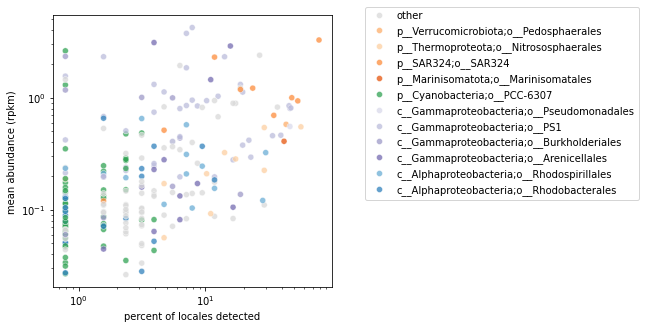

In [357]:
order = ["other"] + sorted([key for key in color_mapping.keys() if key !='other'], reverse=True)

plt.figure(figsize=[5,5])
sns.scatterplot(x="p10.0km", y="rpkm", data=both_gb[both_gb["p10.0km"]>0].query("rpkm!='None'"),
                hue="plot_name", hue_order=order, palette=color_mapping, alpha=0.75)
plt.xlabel("percent of locales detected")
plt.ylabel("mean abundance (rpkm)")
plt.yscale("log")
plt.xscale("log")
plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig(rootdir + "figures/occupancy_scatter.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
plt.show()

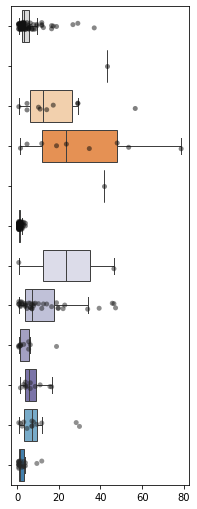

In [358]:
# for this, okay if no corresponding RPKM value
both_gb = merged_gb.merge(abund_gb, how="left", on="genome").fillna("None")#.query("rpkm!='None'")
both_gb["display_name"] = both_gb["classification"].apply(assign_label)
both_gb["plot_name"] = both_gb["display_name"].apply(lambda x: x if x in color_mapping.keys() else "other")

plt.figure(figsize=[3.2,8.8])
sns.boxplot(x="p10.0km", y="plot_name", data=both_gb.sort_values("plot_name"), 
                order=order, hue="plot_name", palette=color_mapping, fliersize=0)
g = sns.stripplot(x="p10.0km", y="plot_name", data=both_gb.sort_values("plot_name"), 
                order=order, hue="plot_name", color="black", alpha=0.5)
g.set(yticklabels=[])
#g.set(xticklabels=[])
plt.xlabel("% deep locales detected")
plt.ylabel("")
plt.xlabel("")
plt.savefig(rootdir + "figures/occupancy_box_wide.svg", format="svg", 
            dpi=300,  bbox_inches="tight", facecolor="white")
#plt.legend(bbox_to_anchor=(1.1, 1.05))
plt.show()

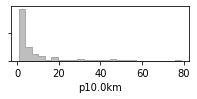

In [359]:
plt.figure(figsize=[3.2,1])
g = sns.histplot(both_gb.sort_values("plot_name")["p10.0km"], element="step", 
             color="darkgray", stat="density", bins=25)
g.set(yticklabels=[])
plt.ylabel("")
plt.savefig(rootdir + "figures/locale_density.svg", format="svg")

### supp

In [360]:
table_s8 = sample_subset[["sample", "dataset", "station", "run_accession",
                          "latitude", "longitude", "depth_numeric", "size_fraction"]]
table_s8 = table_s8.merge(coord_piv[["latitude", "longitude", "c10.0km"]], how="left").fillna("None")
table_s8["locale"] = table_s8.apply(lambda x: str(int(x["c10.0km"])) if x["depth_numeric"] >= 200 else 'None', axis=1)
table_s8.drop(["c10.0km"], axis=1).sort_values(["dataset", "station"]).to_csv(rootdir + "tables/table_s8.tsv", sep="\t", index=False)

In [405]:
filt_results[filt_results["sample"].isin(table_s8["sample"])][["sample", "genome", "length", "coverage", "breadth", "breadth_expected",
              "breadth_ratio", "filtered_read_pair_count", "total_reads", "rpkm"]].to_csv(rootdir + "tables/table_s9.tsv", sep="\t", index=False)